In [259]:
#Import dependicies
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [260]:
 # Name of the CSV file
file = 'Resources/countries_of_the_world.csv'

In [261]:
# The correct encoding must be used to read the CSV in pandas
df = pd.read_csv(file, encoding="ISO-8859-1")

In [262]:
 # Preview of the DataFrame
df.head()

,Country,Region,Population,Area (sq. mi.),Pop. Density (per sq. mi.),Coastline (coast/area ratio),Net migration,Infant mortality (per 1000 births),GDP ($ per capita),Literacy (%),Phones (per 1000),Arable (%),Crops (%),Other (%),Climate,Birthrate,Deathrate,Agriculture,Industry,Service
0,Afghanistan,ASIA (EX. NEAR EAST),31056997,647500,"48,0","0,00","23,06","163,07",700.0,"36,0","3,2","12,13","0,22","87,65",1,"46,6","20,34","0,38","0,24","0,38"
1,Albania,EASTERN EUROPE,3581655,28748,"124,6","1,26","-4,93","21,52",4500.0,"86,5","71,2","21,09","4,42","74,49",3,"15,11","5,22","0,232","0,188","0,579"
2,Algeria,NORTHERN AFRICA,32930091,2381740,"13,8","0,04","-0,39",31,6000.0,"70,0","78,1","3,22","0,25","96,53",1,"17,14","4,61","0,101","0,6","0,298"
3,American Samoa,OCEANIA,57794,199,"290,4","58,29","-20,71","9,27",8000.0,"97,0","259,5",10,15,75,2,"22,46","3,27",NaN,NaN,NaN
4,Andorra,WESTERN EUROPE,71201,468,"152,1","0,00","6,6","4,05",19000.0,"100,0","497,2","2,22",0,"97,78",3,"8,71","6,25",NaN,NaN,NaN


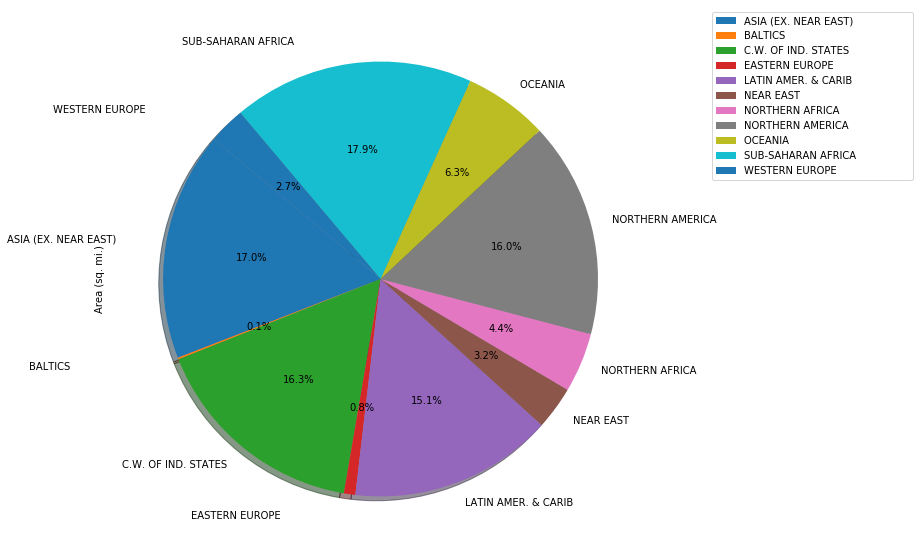

In [263]:
#Create a dataframe with just the data that you need
area_df = df[['Country','Region','Area (sq. mi.)']]
area_df
area_df_grouped = area_df.groupby(['Region'])

area_totaled = area_df_grouped.sum()['Area (sq. mi.)']
area_totaled

area_totaled_df = area_totaled.reset_index()
area_totaled_df


plot = area_totaled_df.plot.pie(y='Area (sq. mi.)', figsize=(10, 10), labels=area_totaled_df['Region'], autopct="%1.1f%%", shadow=True, startangle=140).legend(bbox_to_anchor=(1.1, 1))

In [264]:
#Create a dataframe from the original data that includes country, region, literacy %, phones per 1000, and population
new_df = df[['Country','Region','Population', 'Literacy (%)', 'Phones (per 1000)']]
new_df.head()

,Country,Region,Population,Literacy (%),Phones (per 1000)
0,Afghanistan,ASIA (EX. NEAR EAST),31056997,"36,0","3,2"
1,Albania,EASTERN EUROPE,3581655,"86,5","71,2"
2,Algeria,NORTHERN AFRICA,32930091,"70,0","78,1"
3,American Samoa,OCEANIA,57794,"97,0","259,5"
4,Andorra,WESTERN EUROPE,71201,"100,0","497,2"


In [265]:
#Create DF to show just the columns you will plot
phone_literacy_df = new_df[['Country', 'Literacy (%)', 'Phones (per 1000)']]
phone_literacy_df.head()

,Country,Literacy (%),Phones (per 1000)
0,Afghanistan,"36,0","3,2"
1,Albania,"86,5","71,2"
2,Algeria,"70,0","78,1"
3,American Samoa,"97,0","259,5"
4,Andorra,"100,0","497,2"


In [266]:
#Create two separate data frames - one for country vs literacy % and one for country vs phones per 1000
#Literacy and country df:
literacy_country_df = phone_literacy_df[['Country', 'Literacy (%)']]
literacy_country_df

,Country,Literacy (%)
0,Afghanistan,"36,0"
1,Albania,"86,5"
2,Algeria,"70,0"
3,American Samoa,"97,0"
4,Andorra,"100,0"
...,...,...
222,West Bank,NaN
223,Western Sahara,NaN
224,Yemen,"50,2"
225,Zambia,"80,6"


227
206
206


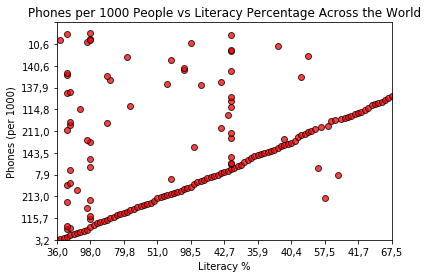

In [333]:
#Phones and country df:
country = phone_literacy_df ['Country'].tolist()
country
print(len(country))

#Filter out NaN values so that you can create scatter plot
phone_literacy_df_filtered  = phone_literacy_df.dropna()
phone_literacy_df_filtered 

literacy = phone_literacy_df_filtered['Literacy (%)'].tolist()
literacy_length = len(literacy)
print(literacy_length)

phones = phone_literacy_df_filtered['Phones (per 1000)'].tolist()
print(len(phones))
#print(phones)

plt.scatter(literacy, phones, marker="o", facecolors="red", edgecolors="black", alpha=0.75)
plt.xlabel('Literacy %')
plt.ylabel('Phones (per 1000)')
plt.title('Phones per 1000 People vs Literacy Percentage Across the World')
plt.figsize=(200,200)
#plt.xticks([]),plt.yticks([])
plt.xticks(np.arange(0, 100+1, 10))
plt.yticks(np.arange(0, 200+1, 20))
plt.xlim(0,100)
plt.ylim(0,200)
plt.show()

In [ ]:
#Create a regression across the above scatter plot
